In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

In [6]:
df = pd.read_csv('/content/sample_data/MSFT_1986-03-13_2025-02-04.csv',parse_dates=['Date'], index_col='Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 1986-03-13 to 2025-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9800 non-null   float64
 1   High       9800 non-null   float64
 2   Low        9800 non-null   float64
 3   Close      9800 non-null   float64
 4   Adj Close  9800 non-null   float64
 5   Volume     9800 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 535.9 KB


In [7]:
pd.DataFrame(df.isna().sum().reset_index(name='Na'))

,index,Na
0,Open,0
1,High,0
2,Low,0
3,Close,0
4,Adj Close,0
5,Volume,0


In [9]:
num_cols = df.select_dtypes(include = {'int64', 'float64'}).columns

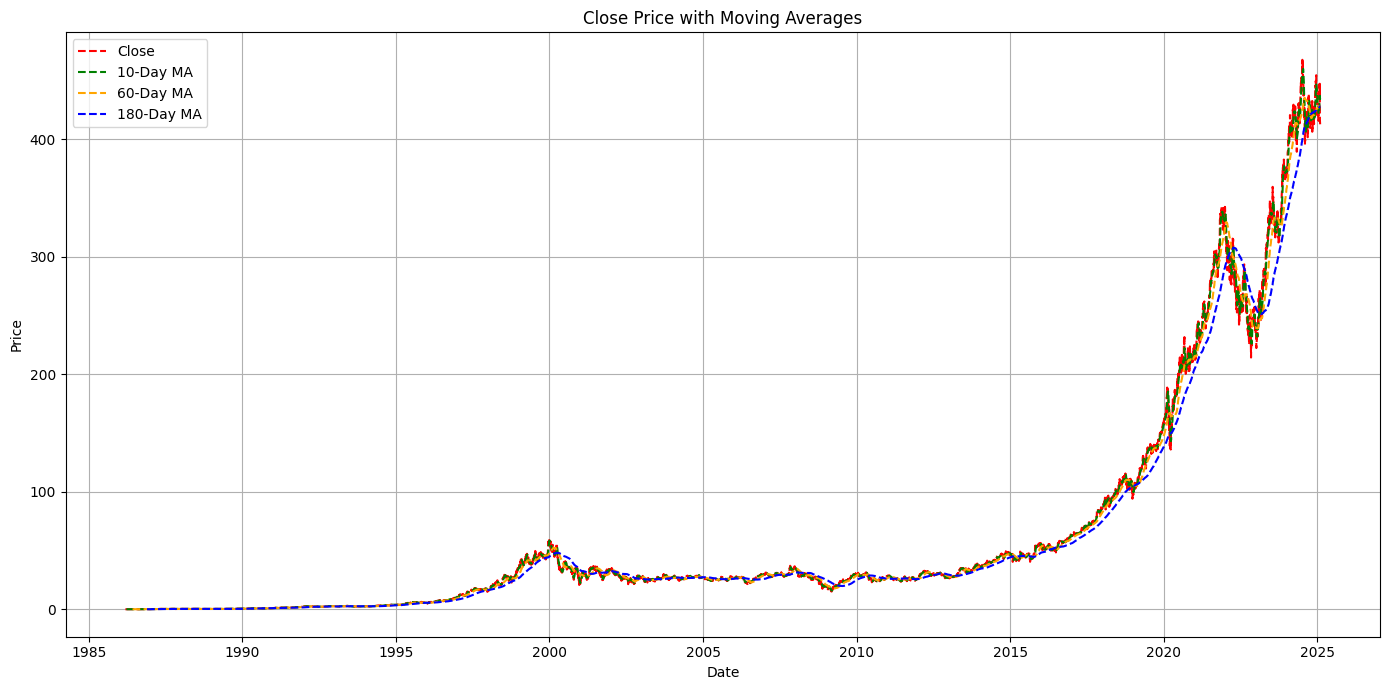

In [12]:
df2 = df.copy()

df2['MA10'] = df2['Close'].rolling(window=10).mean()
df2['MA60'] = df2['Close'].rolling(window=60).mean()
df2['MA180'] = df2['Close'].rolling(window=180).mean()

plt.figure(figsize=(14, 7))

plt.plot(df2.index, df2['Close'], label='Close', color='red', linestyle='--')
plt.plot(df2.index, df2['MA10'], label='10-Day MA', color='green', linestyle='--')
plt.plot(df2.index, df2['MA60'], label='60-Day MA', color='orange', linestyle='--')
plt.plot(df2.index, df2['MA180'], label='180-Day MA', color='blue', linestyle='--')

plt.title('Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import numpy as np

Training data period: 1986-04-25 00:00:00 to 2017-04-26 00:00:00
Testing data period: 2017-04-27 00:00:00 to 2025-02-03 00:00:00


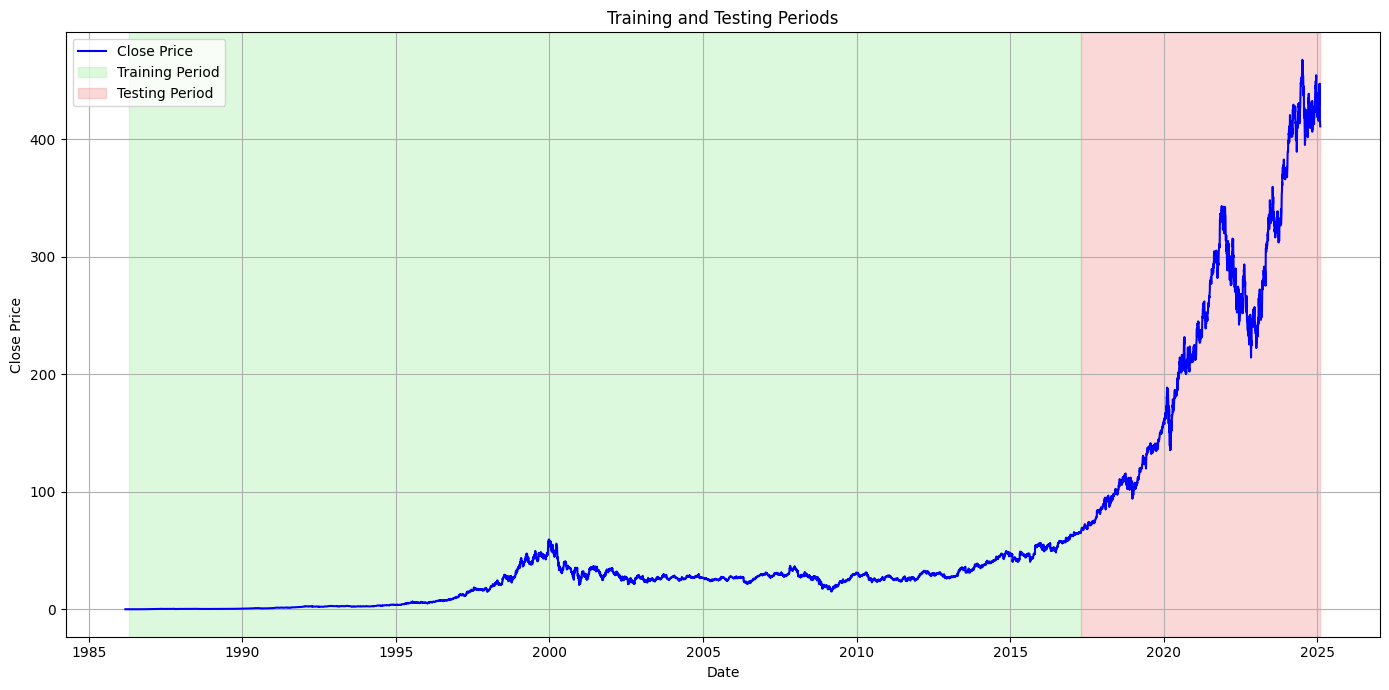

In [16]:
# Feature Selection

df_close = df['Close'].values.reshape(-1, 1)

#Scaling/Normalization (MinMax Scale)

scaler = MinMaxScaler(feature_range=(0, 1))
df_close_scale = scaler.fit_transform(df_close)

# Sequence Creation
sequence_length = 30
X, y = [], []

for i in range(sequence_length, len(df_close_scale)):
    X.append(df_close_scale[i-sequence_length:i])
    y.append(df_close_scale[i])

#Conversion to Arrays
X, y = np.array(X), np.array(y)

# Train Test Split
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dates = df.index[sequence_length:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

# Extraction Index
dates = df.index[sequence_length:]

train_dates = dates[:train_size]
test_dates = dates[train_size:]

# Check Period
print("Training data period: {} to {}".format(train_dates[0], train_dates[-1]))
print("Testing data period: {} to {}".format(test_dates[0], test_dates[-1]))

# Check Plot
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

plt.axvspan(train_dates[0], train_dates[-1], color='lightgreen', alpha=0.3, label='Training Period')
plt.axvspan(test_dates[0], test_dates[-1], color='lightcoral', alpha=0.3, label='Testing Period')

plt.title('Training and Testing Periods')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
model = Sequential()

model.add(Bidirectional(LSTM(units=64, return_sequences=True,
                              kernel_regularizer=l2(0.001),
                              input_shape=(X.shape[1], 1))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(units=64, return_sequences=True,
                              kernel_regularizer=l2(0.001))))
model.add(Dropout(0.5))


model.add(LSTM(units=64, return_sequences=True,
               kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(LSTM(units=32, return_sequences=False,
               kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1))

# Adjust Adam optimizer parameters
adam_optimizer = Adam(learning_rate=0.00001,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-07)

# Compile the model using the custom Adam optimizer
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')


# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


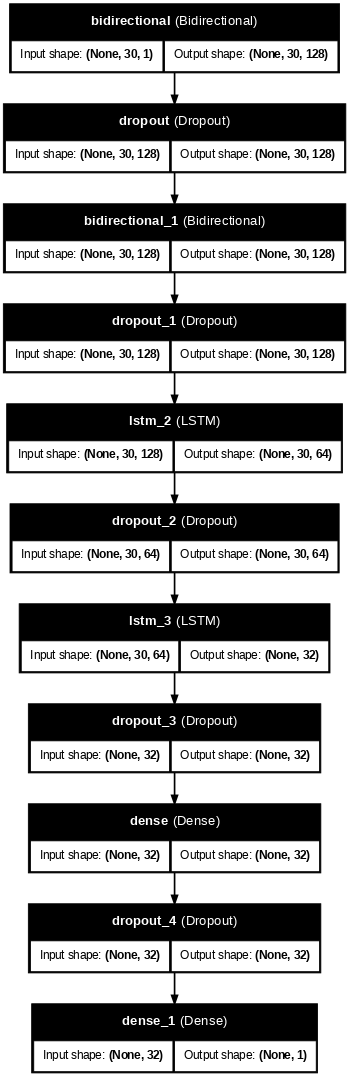

In [18]:
# Manually build the model
model.build(input_shape=(None, X.shape[1], 1))

# Save the model architecture to a file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True, dpi=60)

# Display the model architecture image
Image('model_structure.png')

In [20]:
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - loss: 0.2458 - val_loss: 0.2631
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - loss: 0.2377 - val_loss: 0.2560
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - loss: 0.2301 - val_loss: 0.2454
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - loss: 0.2224 - val_loss: 0.2419
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - loss: 0.2152 - val_loss: 0.2338
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - loss: 0.2078 - val_loss: 0.2237
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - loss: 0.2009 - val_loss: 0.2184
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - loss: 0.1941 - val_loss: 0.2084
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - loss: 0.1875 - val_loss: 0.2022
Epoch 10/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - loss: 0.1805 - val_loss: 0.1952


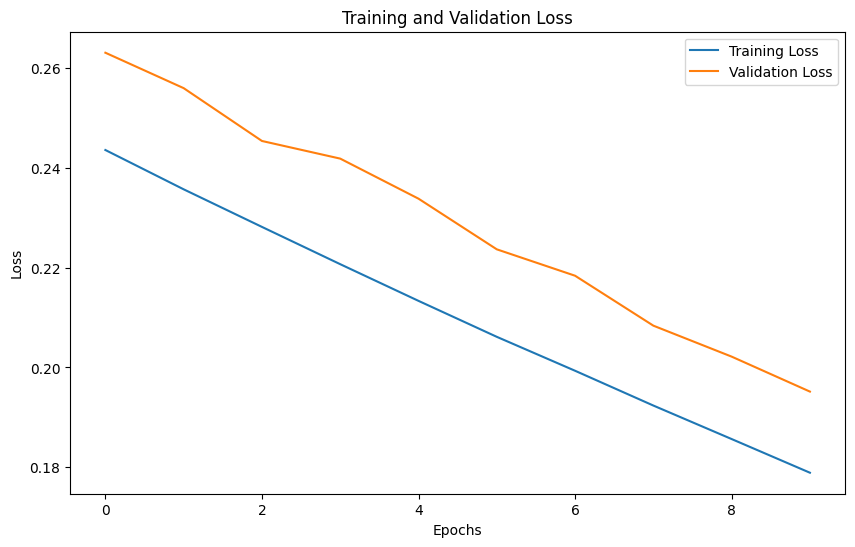

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


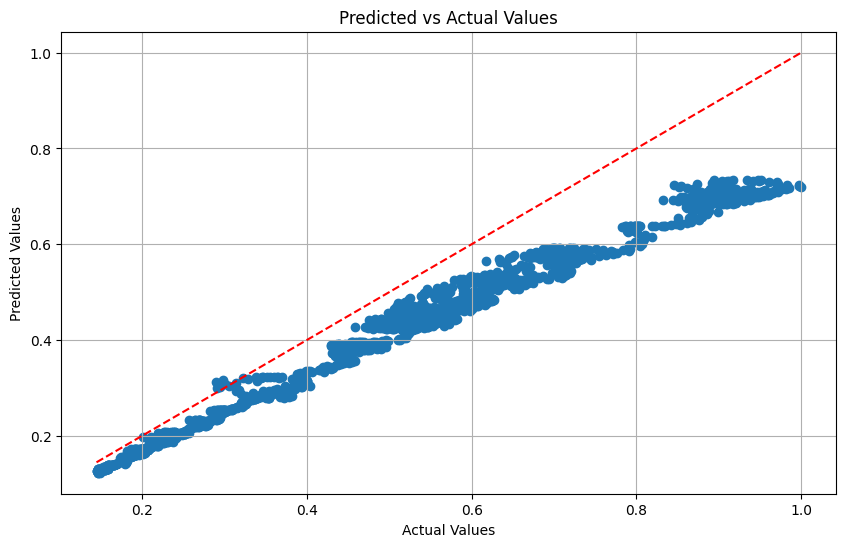

In [22]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()



62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


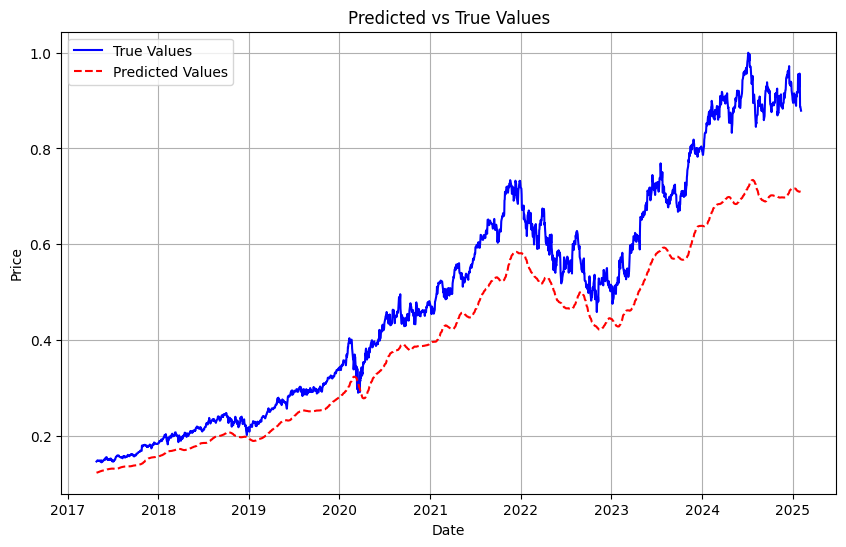

In [23]:
predictions = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 6))

plt.plot(test_dates, y_test, label='True Values', color='blue')
plt.plot(test_dates, predictions, label='Predicted Values', color='red', linestyle='--')

plt.legend()
plt.title('Predicted vs True Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()



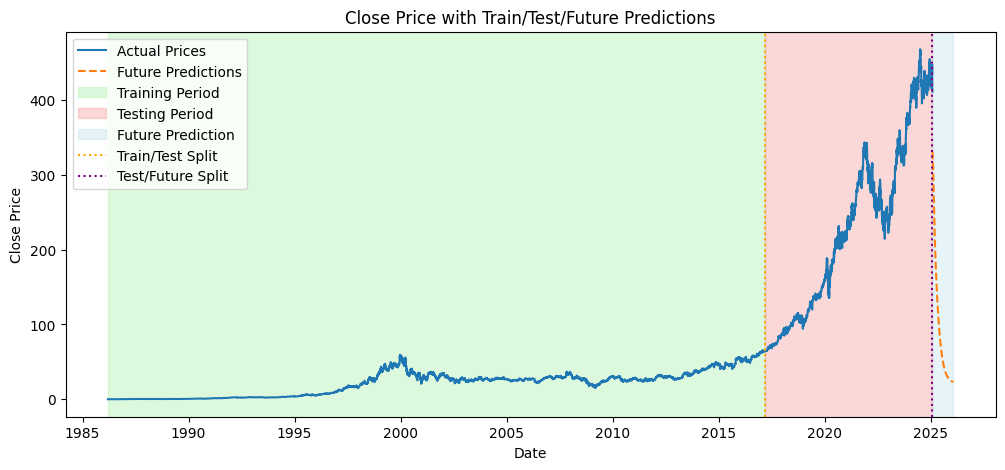

In [24]:


future_predictions = []
last_sequence = df_close_scale[-sequence_length:]

for _ in range(360):

    input_data = last_sequence.reshape(1, sequence_length, 1)

    #prediction
    predicted_price = model.predict(input_data, verbose=0)

    # Store the predicted price
    future_predictions.append(predicted_price[0, 0])

    # Update the input sequence
    last_sequence = np.append(last_sequence[1:], predicted_price, axis=0)

# Inverse scale the predicted values to the original price range
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

plt.figure(figsize=(12, 5))

# Plot actual data (train + test)
plt.plot(df.index, df_close, label='Actual Prices')

# Plot future predictions
future_dates = pd.date_range(df.index[-1], periods=361, freq='D')[1:]
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')

# Label train, test, and future periods
train_end_date = df.index[train_size-1]
test_start_date = df.index[train_size]
test_end_date = df.index[-1]

# Add shaded areas (background color) for train, test, and future periods
plt.axvspan(df.index[0], train_end_date, color='lightgreen', alpha=0.3, label='Training Period')
plt.axvspan(test_start_date, test_end_date, color='lightcoral', alpha=0.3, label='Testing Period')
plt.axvspan(test_end_date, future_dates[-1], color='lightblue', alpha=0.3, label='Future Prediction')

# Add vertical lines to separate the periods
plt.axvline(x = train_end_date, color='orange', linestyle=':', label='Train/Test Split')
plt.axvline(x = test_end_date, color='purple', linestyle=':', label='Test/Future Split')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Close Price with Train/Test/Future Predictions')
plt.show()



#ANOTHER TRY TO GET BETTER PERFORMANCE USING LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
121/121 - 48s - 396ms/step - loss: 1.0568e-04 - val_loss: 0.0015
Epoch 2/15
121/121 - 82s - 681ms/step - loss: 9.5251e-06 - val_loss: 0.0018
Epoch 3/15
121/121 - 85s - 700ms/step - loss: 8.6867e-06 - val_loss: 0.0019
Epoch 4/15
121/121 - 43s - 357ms/step - loss: 8.0103e-06 - val_loss: 0.0017
Epoch 5/15
121/121 - 85s - 704ms/step - loss: 7.3874e-06 - val_loss: 0.0023
Epoch 6/15
121/121 - 82s - 675ms/step - loss: 6.9890e-06 - val_loss: 5.7724e-04
Epoch 7/15
121/121 - 80s - 662ms/step - loss: 6.1489e-06 - val_loss: 5.4744e-04
Epoch 8/15
121/121 - 82s - 681ms/step - loss: 6.4631e-06 - val_loss: 5.2521e-04
Epoch 9/15
121/121 - 83s - 683ms/step - loss: 6.1993e-06 - val_loss: 5.1485e-04
Epoch 10/15
121/121 - 79s - 651ms/step - loss: 6.0076e-06 - val_loss: 4.3731e-04
Epoch 11/15
121/121 - 44s - 366ms/step - loss: 5.5212e-06 - val_loss: 7.1693e-04
Epoch 12/15
121/121 - 82s - 679ms/step - loss: 4.9672e-06 - val_loss: 5.2994e-04
Epoch 13/15
121/121 - 53s - 441ms/step - loss: 5.1330e-06

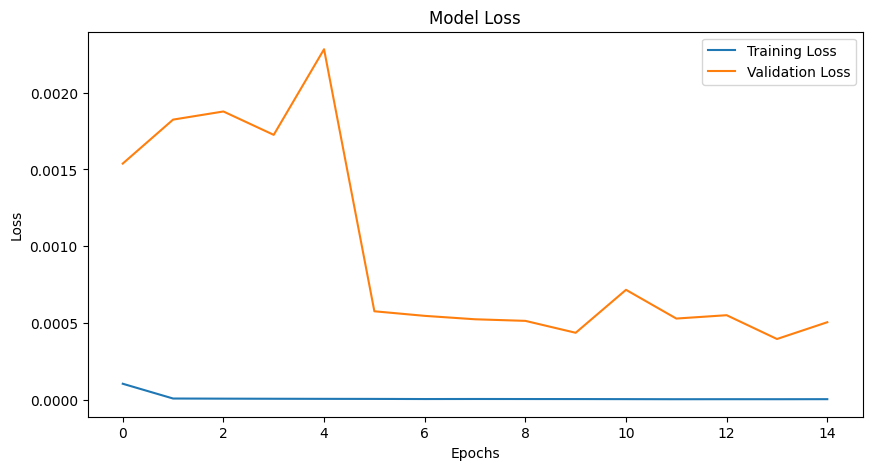

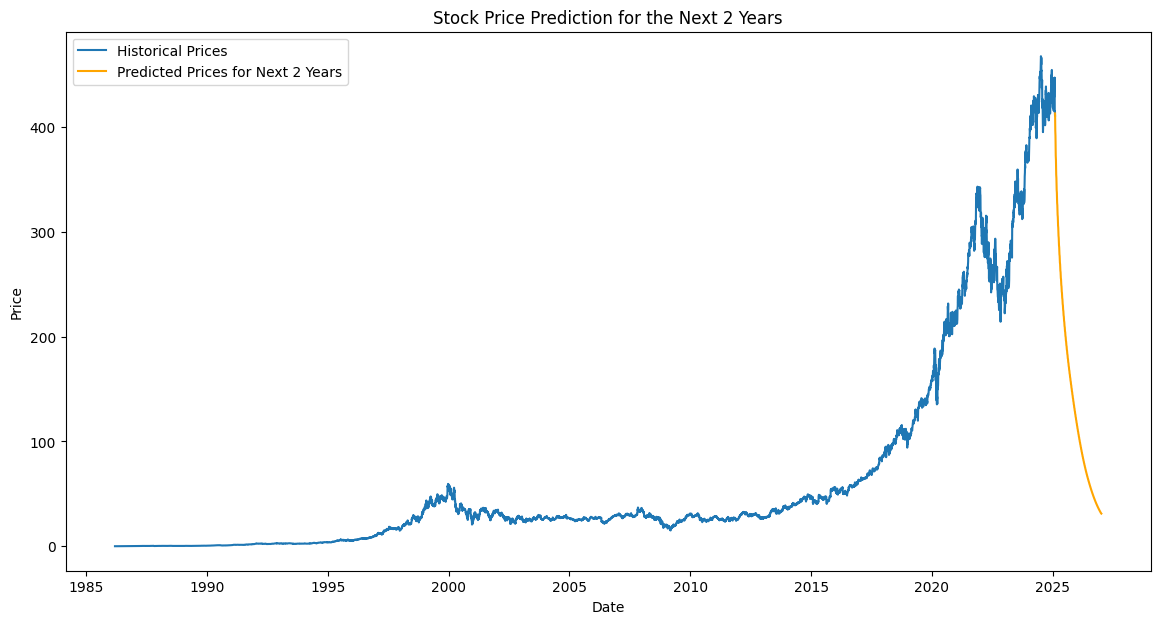

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv("/content/sample_data/MSFT_1986-03-13_2025-02-04.csv")

# Ensure Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort by date and set the index
data = data.sort_values('Date').set_index('Date')

# Use 'Close' prices for prediction
prices = data['Close'].values.reshape(-1, 1)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create a dataset for the LSTM model
def create_dataset(data, look_back=120):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 120
X, y = create_dataset(scaled_prices, look_back)

# Reshape input to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 15  # Increased epochs for better convergence
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict future prices recursively
def predict_future_prices(model, recent_data, days_to_predict, scaler, look_back):
    predictions = []
    current_input = recent_data[-look_back:].reshape(1, look_back, 1)

    for _ in range(days_to_predict):
        next_price_scaled = model.predict(current_input, verbose=0)[0, 0]
        next_price_scaled = max(next_price_scaled, 0.01)  # Avoid negative values
        predictions.append(next_price_scaled)

        # Update the input for the next prediction
        current_input = np.append(current_input[:, 1:, :], [[[next_price_scaled]]], axis=1)

    # Inverse transform the scaled predictions back to the original scale
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predict the next 500 trading days
days_to_predict = 500
predicted_prices = predict_future_prices(model, scaled_prices, days_to_predict, scaler, look_back)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, prices, label='Historical Prices')

# Generate future dates for prediction plot
future_dates = pd.date_range(data.index[-1], periods=days_to_predict + 1, freq='B')[1:]  # Skip the last historical date
plt.plot(future_dates, predicted_prices, label='Predicted Prices for Next 2 Years', color='orange')

plt.title('Stock Price Prediction for the Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()